In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
trades = pd.read_csv("historical_data.csv")
sent   = pd.read_csv("fear_greed_index.csv")

print("Trades columns:", trades.columns.tolist())
print("Sentiment columns:", sent.columns.tolist())

Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [28]:
trade_time_col = "Timestamp IST"
sent_date_col  = "date"
sent_class_col = "classification"

price_col = "Execution Price"
size_col  = "Size USD"
pnl_col   = "Closed PnL"
lev_col   = "Fee"

In [29]:
trades["time"] = pd.to_datetime(trades[trade_time_col], errors="coerce")
trades["trade_date"] = trades["time"].dt.date

sent["trade_date"] = pd.to_datetime(sent[sent_date_col], errors="coerce").dt.date
sent = sent.rename(columns={sent_class_col: "sentiment"})

In [30]:
for c in [price_col, size_col, pnl_col, lev_col]:
    trades[c] = pd.to_numeric(trades[c], errors="coerce")

trades = trades.dropna(subset=[price_col, size_col, pnl_col, lev_col, "trade_date"])
trades["trade_value"]   = trades[price_col] * trades[size_col]
trades["is_profitable"] = (trades[pnl_col] > 0).astype(int)

In [31]:
df = trades.merge(sent[["trade_date", "sentiment"]], on="trade_date", how="left")
df = df.dropna(subset=["sentiment"])  # keep only rows with sentiment

df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,time,trade_date,trade_value,is_profitable,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,62795.433104,0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1018.886400,0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,9188.355865,0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,9121.930296,0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,557.260650,0,Greed


In [32]:
stats = (
    df.groupby("sentiment")
      .agg(
          avg_pnl   = (pnl_col, "mean"),
          avg_lev   = (lev_col, "mean"),
          win_rate  = ("is_profitable", "mean"),
          trades    = ("is_profitable", "size")
      )
      .reset_index()
)

stats["win_rate"] *= 100
print(stats)


       sentiment     avg_pnl   avg_lev   win_rate  trades
0   Extreme Fear    1.891632  0.686479  29.277730    2326
1  Extreme Greed  205.816345  0.835794  55.328233    5621
2           Fear  128.287950  1.131521  38.178672   13869
3          Greed   53.988003  1.092947  43.570670   11292
4        Neutral   27.088803  0.922389  49.492017    2756


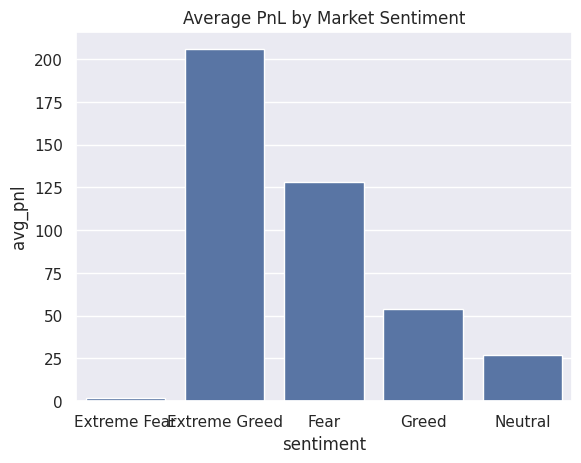

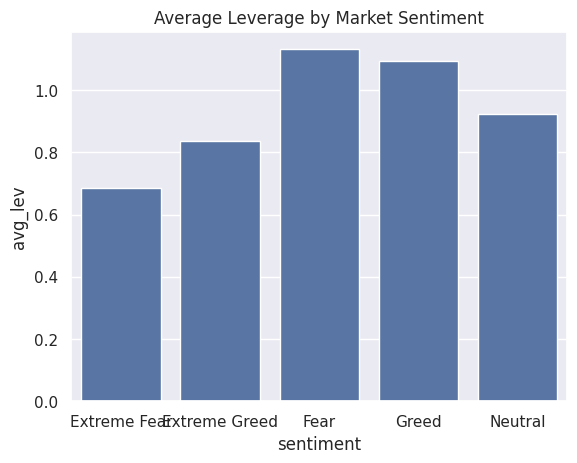

In [33]:
# Avg PnL by sentiment
sns.barplot(data=stats, x="sentiment", y="avg_pnl")
plt.title("Average PnL by Market Sentiment")
plt.show()

# Avg leverage by sentiment
sns.barplot(data=stats, x="sentiment", y="avg_lev")
plt.title("Average Leverage by Market Sentiment")
plt.show()
